#Student Name:
#Student ID:

#Student Name:
#Student ID:

#Student Name:
#Student ID:

#Student Name:
#Student ID:

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

### Parameters
* SEED : Used as value for functions that take a random seed as an argument. The function of this parameter is to ensure repeatability between runs of the notebook
* TEST_SIZE : Used to determine the split of the dataset into a Test set and a Training Set. Needs to be specified as a float between 0.0 and 1.0
* VERBOSE : Enables higher verbosity for debug etc
* COMPONENT_PCT : Determines the percentage of variance that each component must contribute to be included after applying PCA

In [31]:
SEED = 1
TEST_SIZE = 0.3
VERBOSE = False
COMPONENT_PCT = 0.5 # Half a percent

### Dataset
Import the UCI Communities and Crimes dataset using Pandas
Details on the dataset is available at the following [link](http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data)

In [3]:
# Following code is from https://github.com/amclean3695/Communities-and-Crime/blob/master/Communities_and_Crime.ipynb
# TODO : See is there any other means for pulling column names from C45 file format
#Reads in names from textfile and performs regex to extract the attribute names 
textfile = open('communities.names','r')
filetext = textfile.read()
textfile.close()
matches = re.findall(r'-{2}\s(\w+)\:{1}', filetext)
col_names = matches[2:] #corresponds to the 128 attributes

In [4]:
df = pd.read_csv('communities.data', header=None, names=col_names)

#data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
#df = pd.read_csv(data_url, header=None)
# The above code does not work as PythonAnywhere blocks outgoing connections for free accounts to non-whitelisted sites

print("Original Dataset Shape is ", df.shape)


Original Dataset Shape is  (1994, 128)


### Remove Non-Predictive Attributes

Of the 128 attributes loaded, for this dataset it is stated that:

Attribute Information: (122 predictive, 5 non-predictive, 1 goal) 
* state: US state (by number) - not counted as predictive above, but if considered, should be consided nominal (nominal) 
* county: numeric code for county - not predictive, and many missing values (numeric) 
* community: numeric code for community - not predictive and many missing values (numeric) 
* communityname: community name - not predictive - for information only (string) 
* fold: fold number for non-random 10 fold cross validation, potentially useful for debugging, paired tests - not predictive (numeric) 

Therefore, the first five columns shall be removed from the dataset. This reduces the total number of columns from 128 to 123

In [5]:
df = df.drop(['state', 'county', 'community', 'communityname', 'fold'], axis=1)
print("Dataset Shape with non-predictive attributes removed is ", df.shape)


Dataset Shape with non-predictive attributes removed is  (1994, 123)


### Replace Missing Data
The dataset contains many cells that contain '?'. Attributes with more missing data than valid data will be removed from the dataset. For the remaining attributes with missing data, the missing data will be imputed.

The first step is to replace the cells containing '?' with "NaN" (Not a Number)

In [6]:
# Replace '?' with 'NaN'
df = df.replace('?', np.nan)

# Print the top-25 attributes with missing values. 
# Code reused from DePy Talk Notebook in [1]
print("The top 25 attributes with missing data are:")
df.isnull().sum().sort_values(ascending=False).head(25)

The top 25 attributes with missing data are:


LemasSwFTFieldPerPop    1675
PctPolicAsian           1675
PolicBudgPerPop         1675
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicWhite           1675
PctPolicMinor           1675
PolicCars               1675
LemasGangUnitDeploy     1675
LemasPctPolicOnPatr     1675
OfficAssgnDrugUnits     1675
PolicOperBudg           1675
PolicAveOTWorked        1675
NumKindsDrugsSeiz       1675
OtherPerCap                1
PctLess9thGrade            0
PctPopUnderPov             0
dtype: int64

Remove any attributes that have more missing data than valid data

In [7]:
# If a column contains more than 50% of missing data, remove column from dataset
for column in df:
    if(df[column].isnull().sum()>=(df.shape[0]/2)):
        if(VERBOSE==True):
            print("Column ", column, df[column].isnull().sum())
        df = df.drop([column], axis=1)

print("Dataset Shape with attributes with more than 50% missing data removed is ", df.shape)

Dataset Shape with attributes with more than 50% missing data removed is  (1994, 101)


In [8]:
print("The top 5 remaining attributes with missing data are:")
df.isnull().sum().sort_values(ascending=False).head(5)


The top 5 remaining attributes with missing data are:


OtherPerCap       1
PctOccupManu      0
HispPerCap        0
NumUnderPov       0
PctPopUnderPov    0
dtype: int64

There is only one missing value remaining but lets impute it for the craic using code from the DePy_Talk notebook

In [9]:
# The missing cell is cell[130]
# The value before imputing is "NaN"
pre_impute = df['OtherPerCap'][130]

# One option to replace the missing data would be to use the median:
miss_median = df['OtherPerCap'].median()

# Since there is only a single missing value, using an Imputer is overkill.
# However, it is used here for the sake of experimentation

from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df) 
df = pd.DataFrame(data=imp.transform(df) , columns=df.columns)

post_impute = df['OtherPerCap'][130]

print("Cell with Missing Data was df['OtherPerCap'][130]")
print("Prior to imputing, the value of this cell was ",pre_impute)
print("Prior to imputing, the median of this attribute was ", miss_median,"This value could have been used instead of using Simple Imputer")
print("Post imputing, the value of this cell is ", post_impute)


Cell with Missing Data was df['OtherPerCap'][130]
Prior to imputing, the value of this cell was  nan
Prior to imputing, the median of this attribute was  0.25 This value could have been used instead of using Simple Imputer
Post imputing, the value of this cell is  0.2847415955845459


### Outlier Detection

Outlier detection uses the Tukey IQR method presented in the DePy Notebook by April Chen[1]. The find_outliers_tukey() function is reused directly from this notebook.

To allow comparision, the dataset without outliers removed is stored prior to outlier detection and removal. The dataset with outliers removed is also stored. This allows the regression algorithm to be run on both datasets and for the results to be compared

In [11]:
# Store off original dataset without outlier detection and removal
dataset = df.values

# From DePy_Talk Notebook[1]
def find_outliers_tukey(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices, outlier_values

# Get the indices and values for the outliers in the Goal columns
tukey_indices, tukey_values = find_outliers_tukey(df['ViolentCrimesPerPop'])

print("Dataset Shape Before Outlier Removal is ", df.shape)

if(VERBOSE==True):
    print("Outliers = ",len(tukey_indices), "out of ",len(df['ViolentCrimesPerPop']), "in ViolentCrimesPerPop Column")

for i in range(len(tukey_indices)):
    # Drop row containing the outlier
    df = df.drop([tukey_indices[i]], axis=0)
    if(VERBOSE==True):
        print("i : ", i, "Index", tukey_indices[i], "Value", tukey_values[i])
    
print("Dataset Shape After Outlier Removal is ", df.shape)

# Store dataset with outliers removed using Tukey IQR method
tukey_dataset = df.values

Dataset Shape Before Outlier Removal is  (1994, 101)
Dataset Shape After Outlier Removal is  (1884, 101)


### Split Up Dataset

Use train_test_split() to split the dataset into a Training Set and a Test Set. The split is determined by the parameter TEST_SIZE

In [12]:
# The Dataset shape is (1994, 101). THe first 100 columns are the attributes and the final column is the goal 
X = dataset[:, 0:100]
y = dataset[:, 100]

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED) 

### Scale the Dataset

Scaling was introduced in Lab 3 of CE4031 Deep Learning module. The scaling performed here follows the method outlined in that lab.

StandardScaler() is used to standardize the features by removing the mean and scaling to unit variance

The fit function is first used on the training data to calculate the mean and the standard deviation. The transform function is then applied independently to the training data and the test data


In [13]:
# Scale the dataset
from sklearn.preprocessing import StandardScaler 
# Scale the data with respect to the training data set 
scaler = StandardScaler() 
scaler.fit(X_train) 

X_scaled_train = scaler.transform(X_train) 
# Scaling the test set using the transform defined by the train set. 
X_scaled_test = scaler.transform(X_test) 

### Lasso Model

Lasso stands for Least Absolute Shrinkage and Selection Operator and is a regression algorithm available in within SciKit Learn. Details are available at <a href="https://en.wikipedia.org/wiki/Lasso_(statistics)">[3]</a>

Lasso is a linear model trained with l1 prior as a regularizer. The regularization is controlled by the constant alpha. Alpha can vary between 0 and 1. A quick survey of reference implementations of Lasso show a value of alpha=0.1 being most commonly used. This is used here initially but subsequently will be improved upon using a grid search with LassoCV


In [14]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_scaled_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
#### Function to Print Model Scores

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def print_model_scores(y_hat, y, print_scores=True):
    mae = mean_absolute_error(y, y_hat)
    mse = mean_squared_error(y, y_hat)
    r2s = r2_score(y, y_hat)
    if(print_scores==True):
        print("MAE       :", mae)
        print("MSE       :", mse)
        print("R^2 Score :",r2s)
    
    return mae, mse, r2s

In [17]:
# Determine accuracy using the train set
y_hat_train = clf.predict(X_scaled_train)

print("Lasso Model Train Accuracy")
print_model_scores(y_hat_train, y_train)

Lasso Model Train Accuracy
MAE       : 0.1356003604079766
MSE       : 0.033043271455379934
R^2 Score : 0.40135360420320854


(0.1356003604079766, 0.033043271455379934, 0.40135360420320854)

In [19]:
# Determine the accuracy using the test test
y_hat = clf.predict(X_scaled_test)

print("Lasso Model Test Accuracy")
print_model_scores(y_hat, y_test)

Lasso Model Test Accuracy
MAE       : 0.13419270424585658
MSE       : 0.03175659751346362
R^2 Score : 0.3895474282936744


(0.13419270424585658, 0.03175659751346362, 0.3895474282936744)

### Gridsearch

The initial Lasso model used an alpha value of 0.1. This value was not determined experimentally and instead was used as it is the most common value in reference implementations.

SciKit-Learn provides a cross-validation option for using Lasso, LassoCV(), that sets the Lasso alpha value by iterating through a number of values and then selecting the value of alpha that delivers the best model

In [20]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000, random_state=SEED) 
lasso_cv.fit(X_scaled_train, y_train)
print("The value of Alpha determined by cross validation is ", lasso_cv.alpha_)


# Determine accuracy using the train set
y_hat_cv_train = clf.predict(X_scaled_train)

print("Lasso CV Model Train Accuracy")
print_model_scores(y_hat_cv_train, y_train)

The value of Alpha determined by cross validation is  0.000498969217524633
Lasso CV Model Train Accuracy
MAE       : 0.1356003604079766
MSE       : 0.033043271455379934
R^2 Score : 0.40135360420320854


(0.1356003604079766, 0.033043271455379934, 0.40135360420320854)

In [21]:
y_hat_cv = lasso_cv.predict(X_scaled_test)

print("Lasso Model Test Accuracy")
print_model_scores(y_hat_cv, y_test)

Lasso Model Test Accuracy
MAE       : 0.09352252159300008
MSE       : 0.018937740495832415
R^2 Score : 0.6359624993487838


(0.09352252159300008, 0.018937740495832415, 0.6359624993487838)

### PCA

In [33]:
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(X_scaled_train)
X_pca_train = pca.transform(X_scaled_train)
X_pca_test = pca.transform(X_scaled_test)

# n_components_pca = 0

# percent_contrib = COMPONENT_PCT

# for i in range(len(pca.explained_variance_)):
#     if(pca.explained_variance_ratio_[i]>=(percent_contrib/100)):
#         n_components_pca+=1
# print("Number of PCA components that contribute >=",percent_contrib,"% of variance is ",n_components_pca)

# pca_red = PCA(n_components=n_components_pca)
# pca_red.fit(X_scaled_train)
# X_pca_red_train = pca_red.transform(X_scaled_train)
# X_pca_red_test = pca_red.transform(X_scaled_test)
# print(pca_red.explained_variance_)
# print(len(pca_red.explained_variance_))
# print(X_pca_red_train.shape)
# print(X_pca_red_test.shape)
# print(type(pca_red.explained_variance_))
# print(pca_red.explained_variance_.sum())
# print(pca_red.explained_variance_ratio_)
    

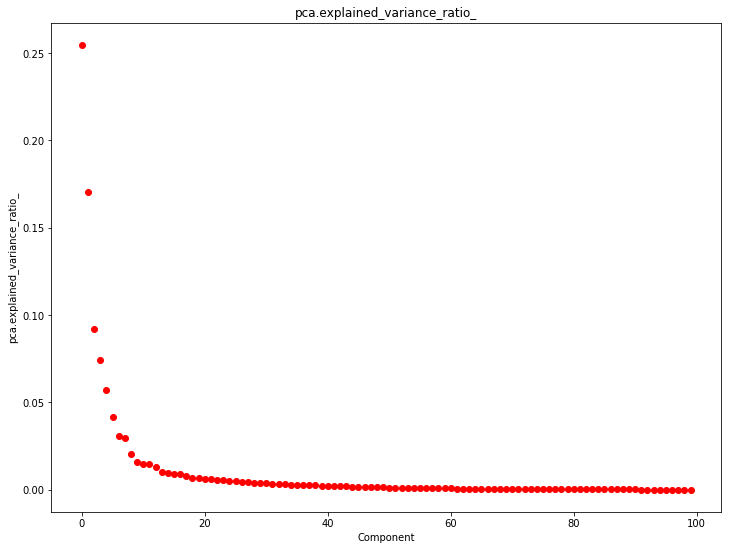

The explained variance ratio shows how much each component contributes to overall variance.
The total overall variance is 1.0
The first component of the PCA analysis contributes over 25% of the total variance
After about 20 components, the amount of variance contributed by each component starts getting to 1% or less


In [46]:
# Adjust Size of Figures
plt.rcParams["figure.figsize"] = (12,9)


plt.title('pca.explained_variance_ratio_')
plt.ylabel('pca.explained_variance_ratio_')
plt.xlabel('Component')
plt.plot(pca.explained_variance_ratio_, 'or')
plt.show()

print("The explained variance ratio shows how much each component contributes to overall variance.")
print("The total overall variance is 1.0")
print("The first component of the PCA analysis contributes over 25% of the total variance")
print("After about 20 components, the amount of variance contributed by each component starts getting to 1% or less")



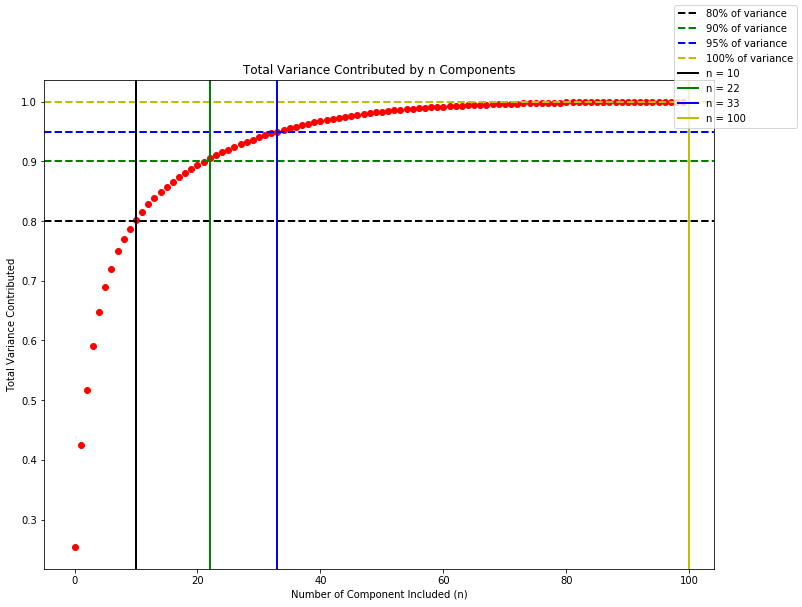

The plot shows the total variance contributed by n components
For example, if all 100 components are included, then 100% of the variance is contributed
However, you can see that if just 10 components are included, 80% of the variance is contributed
Similarly, by including the first 22 components from PCA, 90% of the variance is contributed
To get to 95%, 33 components need to be included. 
The remaining 5% requires an additional 67 components to be included


In [77]:
explained_variance_sum = np.zeros(len(pca.explained_variance_ratio_))

ratio_spread = np.zeros(8)
ratios = ['>50% Variance', '>25% Variance', '>10% Variance', '>5% Variance', '>2% Variance', '>1% Variance', '>0.5%Variance', '<0.5% Variance']

for i in range(len(pca.explained_variance_ratio_)):
    if(i==0):
        explained_variance_sum[0] = pca.explained_variance_ratio_[0]
    else:
        explained_variance_sum[i] = explained_variance_sum[i-1] + pca.explained_variance_ratio_[i]
    if(pca.explained_variance_ratio_[i]>=0.5):
        ratio_spread[0]+=1
    if(pca.explained_variance_ratio_[i]>=0.25):
        ratio_spread[1]+=1
    if(pca.explained_variance_ratio_[i]>=0.1):
        ratio_spread[2]+=1
    if(pca.explained_variance_ratio_[i]>=0.05):
        ratio_spread[3]+=1
    if(pca.explained_variance_ratio_[i]>=0.02):
        ratio_spread[4]+=1
    if(pca.explained_variance_ratio_[i]>=0.01):
        ratio_spread[5]+=1
    if(pca.explained_variance_ratio_[i]>=0.005):
        ratio_spread[6]+=1
    if(pca.explained_variance_ratio_[i]<0.005):
        ratio_spread[7]+=1
    if(VERBOSE==True):
        print("i", i, "value", explained_variance_sum[i])
    
plt.title('Total Variance Contributed by n Components')
plt.ylabel('Total Variance Contributed')
plt.xlabel('Number of Component Included (n)')
plt.plot(explained_variance_sum, 'or')
plt.axhline(0.8, color='k', linestyle='dashed', linewidth=2, label='80% of variance')
plt.axhline(0.9, color='g', linestyle='dashed', linewidth=2, label='90% of variance')
plt.axhline(0.95, color='b', linestyle='dashed', linewidth=2, label='95% of variance')
plt.axhline(1.0, color='y', linestyle='dashed', linewidth=2, label='100% of variance')
plt.axvline(10, color='k', linestyle='solid', linewidth=2, label='n = 10')
plt.axvline(22, color='g', linestyle='solid', linewidth=2, label='n = 22')
plt.axvline(33, color='b', linestyle='solid', linewidth=2, label='n = 33')
plt.axvline(100, color='y', linestyle='solid', linewidth=2, label='n = 100')
plt.figlegend()
plt.show()

print("The plot shows the total variance contributed by n components")
print("For example, if all 100 components are included, then 100% of the variance is contributed")
print("However, you can see that if just 10 components are included, 80% of the variance is contributed")
print("Similarly, by including the first 22 components from PCA, 90% of the variance is contributed")
print("To get to 95%, 33 components need to be included. \nThe remaining 5% requires an additional 67 components to be included")



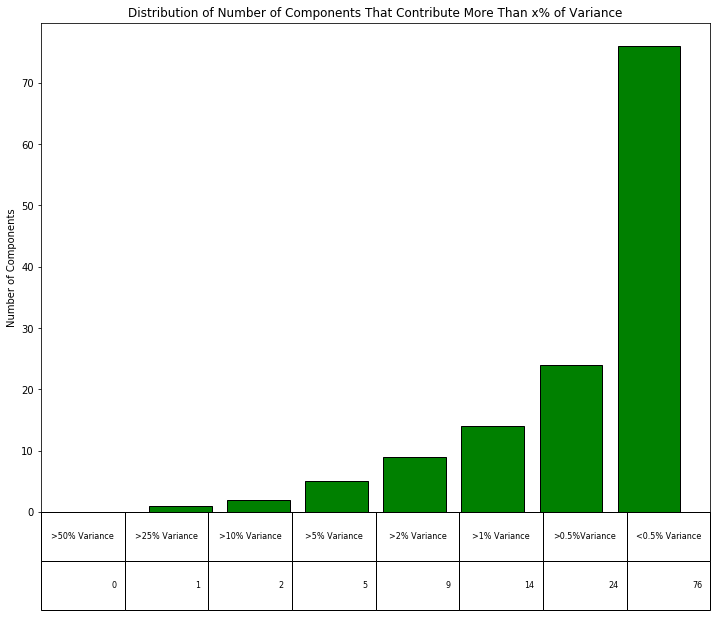

In [88]:
plt.bar([1,2,3,4,5,6,7,8],ratio_spread,facecolor='green', edgecolor='black')
plt.ylabel('Number of Components')
plt.title('Distribution of Number of Components That Contribute More Than x% of Variance')
# From https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
# Remove ticks and labels from X-axis
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
the_table = plt.table(cellText=(ratio_spread.astype(int).reshape(1,8)),colLabels=ratios,loc='bottom')
# From https://stackoverflow.com/questions/9932072/matplotlib-table-formatting
# Adjust cell height
table_props = the_table.properties()
table_cells = table_props['child_artists']
for cell in table_cells: cell.set_height(0.1)
plt.show()



In [80]:
n_components_pca = 0

percent_contrib = COMPONENT_PCT

# Determine the number of components that contribute more than 'percent_contrib' of variance and use this for the PCA value
for i in range(len(pca.explained_variance_)):
    if(pca.explained_variance_ratio_[i]>=(percent_contrib/100)):
        n_components_pca+=1
print("Number of PCA components that contribute >=",percent_contrib,"% of variance is ",n_components_pca)
print("These components contribute", pca_red.explained_variance_.sum(), "% of the total variance" )

pca_red = PCA(n_components=n_components_pca)
pca_red.fit(X_scaled_train)
X_pca_red_train = pca_red.transform(X_scaled_train)
X_pca_red_test = pca_red.transform(X_scaled_test)
if (VERBOSE==True):
    print(pca_red.explained_variance_)
    print(len(pca_red.explained_variance_))
    print(X_pca_red_train.shape)
    print(X_pca_red_test.shape)
    print(type(pca_red.explained_variance_))
    print(pca_red.explained_variance_.sum())


Number of PCA components that contribute >= 0.5 % of variance is  24
These components contribute 91.08888345825598 % of the total variance


In [84]:
clf_pca = linear_model.Lasso(alpha=0.1)
clf_pca.fit(X_pca_red_train, y_train)
y_pca_red_hat = clf_pca.predict(X_pca_red_test)

if(VERBOSE==True):
    print(y_pca_red_hat.shape)
    print(y_test.shape)
    print(y_pca_red_hat[0:5])
    print(y_test[0:5])
    print(clf_pca.score(X_pca_red_test,y_test))

print("Lasso Model Score on PCA-reduced Data Using Alpha=","0.1")
print_model_scores(y_pca_red_hat, y_test)


Lasso Model Score on PCA-reduced Data Using Alpha= 0.1
MAE       : 0.11629493276302312
MSE       : 0.02679438384848385
R^2 Score : 0.4849353580572111


(0.11629493276302312, 0.02679438384848385, 0.4849353580572111)

In [85]:
lasso_pca_cv = LassoCV(alphas = None, cv = 10, max_iter = 1000, random_state=SEED) 
lasso_pca_cv.fit(X_pca_red_train, y_train)

print(lasso_pca_cv.alpha_)

y_pca_red_hat_cv = lasso_pca_cv.predict(X_pca_red_test)
if(VERBOSE==True):
    print(y_pca_red_hat_cv[0:20])
    print(y_test[0:20])

print("Lasso CV Model Score on PCA-reduced Data Using Alpha=",lasso_pca_cv.alpha_)
print_model_scores(y_pca_red_hat_cv, y_test)

0.0018467488631618402
Lasso CV Model Score on PCA-reduced Data Using Alpha= 0.0018467488631618402
MAE       : 0.09510153221138339
MSE       : 0.019470631871788296
R^2 Score : 0.6257188039795154


(0.09510153221138339, 0.019470631871788296, 0.6257188039795154)

### Finally we will visualize the results by comparing predictive power of n_components classifier, original_classifier and the classifier after grid search

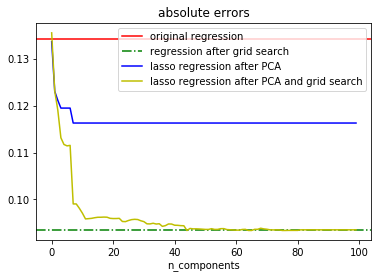

original_regression: 0.13419270424585658
regression after grid search: 0.09352252159300008
regression after PCA: 0.11629496527175333
regression after PCA and grid search: 0.09348122155161291


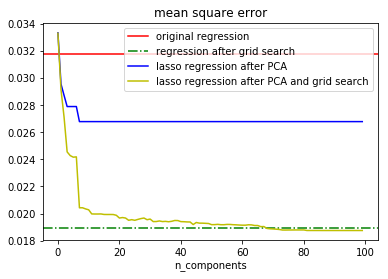

original_regression: 0.03175659751346362
regression after grid search: 0.018937740495832415
regression after PCA: 0.026794396120327812
regression after PCA and grid search: 0.018743840953422887


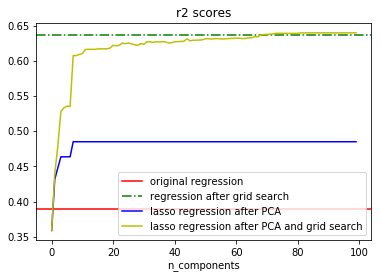

original_regression: 0.3895474282936744
regression after grid search: 0.6359624993487838
regression after PCA: 0.4849351221572945
regression after PCA and grid search: 0.639689802762394


In [45]:
pca_for_count_of_components = PCA()
pca_for_count_of_components.fit(X_scaled_train)
total_components = len(pca.explained_variance_)
pca_results_n_components_lasso = []
pca_results_n_components_lasso_cv = []

for i in range(total_components):
    pca_n = PCA(n_components=i+1)
    pca_n.fit(X_scaled_train)
    X_pca_n_train = pca_n.transform(X_scaled_train)
    X_pca_n_test = pca_n.transform(X_scaled_test)
    clf_pca = linear_model.Lasso(alpha=0.1)
    clf_pca.fit(X_pca_n_train, y_train)
    y_n_hat = clf_pca.predict(X_pca_n_test)
    #mae = mean_absolute_error(y_test, y_n_hat)
    #mse = mean_squared_error(y_test, y_n_hat)
    #r2s = r2_score(y_test, y_n_hat)
    mae, mse, r2s = print_model_scores(y_n_hat, y_test, print_scores=False)
    pca_results_n_components_lasso.append((mae,mse,r2s))
    
    lasso_pca_cv_n = LassoCV(alphas = None, cv = 10, max_iter = 1000, random_state=SEED) 
    lasso_pca_cv_n.fit(X_pca_n_train, y_train)
    y_n_hat_cv = lasso_pca_cv_n.predict(X_pca_n_test)
    #mae_cv = mean_absolute_error(y_test, y_n_hat_cv)
    #mse_cv = mean_squared_error(y_test, y_n_hat_cv)
    #r2s_cv = r2_score(y_test, y_n_hat_cv)
    mae_cv, mse_cv, r2s_cv = print_model_scores(y_n_hat_cv, y_test, print_scores=False)
    pca_results_n_components_lasso_cv.append((mae_cv,mse_cv,r2s_cv))
    
    
maes, mses, r2ss = zip(*pca_results_n_components_lasso)
maes_cv, mses_cv, r2ss_cv = zip(*pca_results_n_components_lasso_cv)

#from matplotlib.pylab import plt #load plot library
# indicate the output of plotting function is printed to the notebook
%matplotlib inline 


#mae_original =  mean_absolute_error(y_test, y_hat)
#mse_original =  mean_squared_error(y_test, y_hat)
#r2s_original = r2_score(y_test, y_hat)
mae_original, mse_original, r2s_original = print_model_scores(y_hat, y_test, print_scores=False)

#mae_cv =  mean_absolute_error(y_test, y_hat_cv)
#mse_cv =  mean_squared_error(y_test, y_hat_cv)
#r2s_cv = r2_score(y_test, y_hat_cv)
mae_cv, mse_cv, r2s_cv = print_model_scores(y_hat_cv, y_test, print_scores=False)

plt.title("absolute errors")
plt.xlabel("n_components")
plt.axhline(y=mae_original, color='r', linestyle='-', label="original regression")
plt.axhline(y=mae_cv, color='g', linestyle='-.', label="regression after grid search")
plt.plot(maes, color='b', label="lasso regression after PCA")
plt.plot(maes_cv, color='y', label="lasso regression after PCA and grid search")
plt.legend(loc='best')
plt.show()
print("original_regression: {}".format(mae_original))
print("regression after grid search: {}".format(mae_cv))
print("regression after PCA: {}".format(maes[-1]))
print("regression after PCA and grid search: {}".format(maes_cv[-1]))

plt.title("mean square error")
plt.xlabel("n_components")
plt.axhline(y=mse_original, color='r', linestyle='-', label="original regression")
plt.axhline(y=mse_cv, color='g', linestyle='-.', label="regression after grid search")
plt.plot(mses, color='b', label="lasso regression after PCA")
plt.plot(mses_cv, color='y', label="lasso regression after PCA and grid search")
plt.legend(loc='best')
plt.show()
print("original_regression: {}".format(mse_original))
print("regression after grid search: {}".format(mse_cv))
print("regression after PCA: {}".format(mses[-1]))
print("regression after PCA and grid search: {}".format(mses_cv[-1]))

plt.title("r2 scores")
plt.xlabel("n_components")
plt.axhline(y=r2s_original, color='r', linestyle='-', label="original regression")
plt.axhline(y=r2s_cv, color='g', linestyle='-.', label="regression after grid search")
plt.plot(r2ss, color='b', label="lasso regression after PCA")
plt.plot(r2ss_cv, color='y', label="lasso regression after PCA and grid search")
plt.legend(loc='best')
plt.show()
print("original_regression: {}".format(r2s_original))
print("regression after grid search: {}".format(r2s_cv))
print("regression after PCA: {}".format(r2ss[-1]))
print("regression after PCA and grid search: {}".format(r2ss_cv[-1]))

#### References
* [1] [Depy 2016 Talk: Pre-Modeling: Data Preprocessing and Feature Exploration in Python Notebook](https://github.com/aprilypchen/depy2016/blob/master/DePy_Talk.ipynb)
* [2] [amclean3695's Communities-and-Crime Notebook](https://github.com/amclean3695/Communities-and-Crime/blob/master/Communities_and_Crime.ipynb)
* [3] <a href="https://en.wikipedia.org/wiki/Lasso_(statistics)">LASSO Algorithm Wikipedia Entry</a>
